<a href="https://colab.research.google.com/github/Dipto1971/Retail-Store-Inventory-Forecasting/blob/main/Thesis_Retail_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
from scipy.stats import shapiro, normaltest
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.formula.api import ols

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "retail_store_inventory.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "anirudhchauhan/retail-store-inventory-forecasting-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

In [ ]:
df.info()

In [ ]:
print("\nSummary Statistics for Numerical Columns:")
print(df.describe())

In [ ]:
# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# ==============================
# Visualizations
# ==============================

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Distribution Plots for Numerical Columns


In [ ]:
# 1. Distribution Plots for Numerical Columns
num_cols = ['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Competitor Pricing']

for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Distribution Plots for Categorical Columns


In [ ]:
# 2. Count Plots for Categorical Columns
cat_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']

for col in cat_cols:
    plt.figure(figsize=(12, 4))
    order = df[col].value_counts().index  # sort by frequency
    sns.countplot(x=col, data=df, order=order)
    plt.title(f'Count Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

# Time Series Analysis: Daily Total Units Sold

In [ ]:
# 3. Time Series Analysis: Daily Total Units Sold
daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()
plt.figure(figsize=(18, 6))
sns.lineplot(x='Date', y='Units Sold', data=daily_sales)
plt.title('Daily Total Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.show()

# Correlation HeatMap

In [ ]:
# 4. Correlation Matrix Heatmap for Numerical Features
numeric_columns = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
corr = df[numeric_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [ ]:
# 5. Box Plot: Units Sold Distribution by Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Units Sold', data=df)
plt.title('Units Sold Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.show()

# Monthly Sales Trend

In [ ]:
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Units Sold'].sum().reset_index()
monthly_sales['Date'] = monthly_sales['Date'].dt.to_timestamp()
plt.figure(figsize=(18, 6))
plt.plot(monthly_sales['Date'], monthly_sales['Units Sold'])
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

# Challenge 2: Inventory Optimization

In [ ]:
plt.figure(figsize=(18, 6))
sns.lineplot(x='Date', y='Inventory Level', data=df)
plt.title('Inventory Level Over Time')
plt.show()

In [ ]:
# Calculate stockout frequency
stockout_freq = (df['Inventory Level'] == 0).mean()
print(f"Stockout frequency: {stockout_freq:.2%}")

In [ ]:
# Calculate overstock frequency
avg_daily_sales = df.groupby('Date')['Units Sold'].mean().mean()
overstock_freq = (df['Inventory Level'] > 2 * avg_daily_sales).mean()
print(f"Overstock frequency: {overstock_freq:.2%}")

In [ ]:
# Sort the DataFrame by date and store/product ID to ensure correct lag and rolling calculations
df = df.sort_values(['Store ID', 'Product ID', 'Date'])

# Create lag features
for lag in [1, 7]:
    df[f'Sales_Lag_{lag}'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].shift(lag)

# Create rolling mean features
for window in [7, 14]:
    df[f'Sales_RollingMean_{window}'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

# Add day of week and month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# Print the shape of the DataFrame after dropping NA values
print(f"Shape before dropping NA: {df.shape}")

# Handle missing values
df = df.dropna()

# Print the shape of the DataFrame after dropping NA values
print(f"Shape after dropping NA: {df.shape}")

# Check the created features
print(df[['Units Sold'] + [f'Sales_Lag_{lag}' for lag in [1, 7]] + [f'Sales_RollingMean_{window}' for window in [7, 14]] + ['DayOfWeek', 'Month']].head())

In [ ]:
import pandas as pd
import numpy as np

# For splitting the data and evaluating models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# For scaling (used by Linear Regression)
from sklearn.preprocessing import StandardScaler

In [ ]:
# Define features and target. (Make sure these columns exist in df.)
features = [
    'Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price',
    'Discount', 'Competitor Pricing', 'Sales_Lag_1', 'Sales_Lag_7',
    'Sales_RollingMean_7', 'Sales_RollingMean_14', 'DayOfWeek', 'Month'
]
target = 'Units Sold'

# Create feature matrix X and target vector y
X = df[features]
y = df[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features for models that benefit from scaling (e.g., Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define our five models in a dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Dictionary to store model results
results = {}

# Train and evaluate each model
for name, model in models.items():
    if name == 'Linear Regression':
        # Use scaled features for Linear Regression
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
    else:
        # For tree-based methods, use unscaled features
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

    # Calculate RMSE and R2 Score
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    results[name] = {'RMSE': rmse, 'R2': r2}

# Print results for each model
for model_name, scores in results.items():
    print(f"{model_name}: RMSE = {scores['RMSE']:.3f}, R2 = {scores['R2']:.3f}")

# Determine the best scoring model based on RMSE (lower RMSE is better)
best_model = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest performing model: {best_model}")


Linear Regression: RMSE = 8.641, R2 = 0.994
Decision Tree: RMSE = 11.878, R2 = 0.988
Random Forest: RMSE = 8.568, R2 = 0.994
Gradient Boosting: RMSE = 8.477, R2 = 0.994
XGBoost: RMSE = 8.548, R2 = 0.994

Best performing model: Gradient Boosting


Plotting learning curve for Linear Regression...


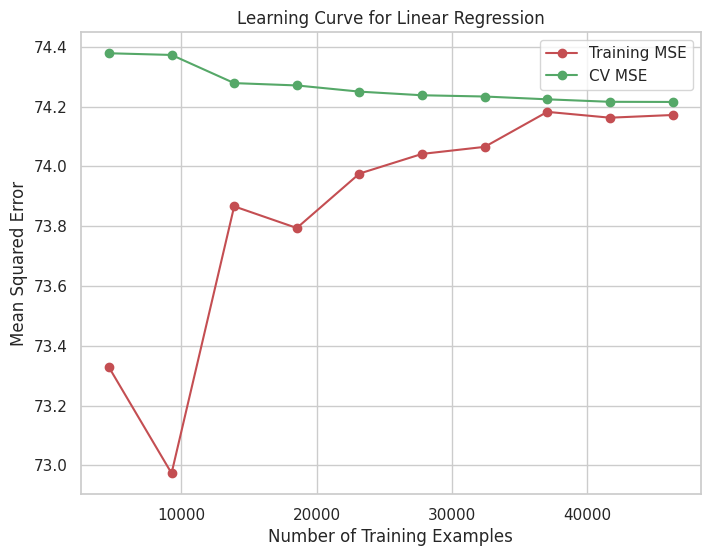

Plotting learning curve for Decision Tree...


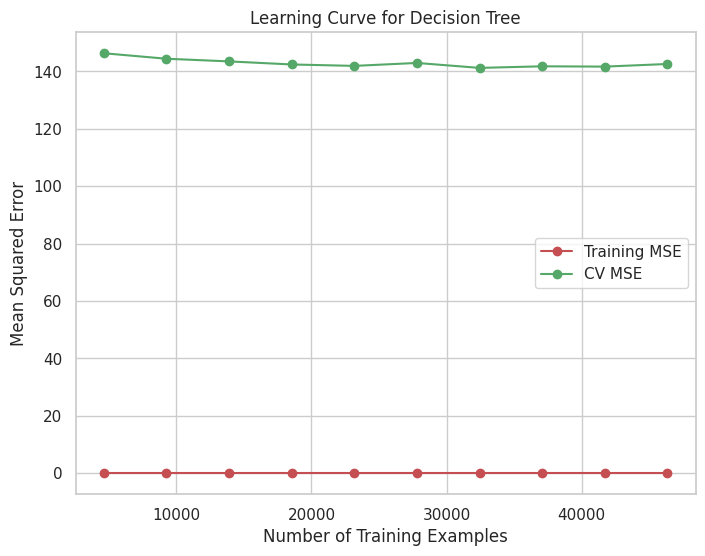

Plotting learning curve for Random Forest...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
def plot_learning_curve(model, X, y, cv, scoring, title):
    """
    Plot learning curve for a given model.

    Parameters:
        model    : The machine learning model (estimator).
        X        : Feature matrix.
        y        : Target vector.
        cv       : Number of cross-validation folds.
        scoring  : Scoring metric (use 'neg_mean_squared_error' for MSE).
        title    : Plot title.
    """
    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),  # from 10% to 100% of training data
        n_jobs=-1  # use all processors if possible
    )

    # Since we're using negative MSE, convert scores to positive MSE
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV MSE")
    plt.title(title)
    plt.xlabel("Number of Training Examples")
    plt.ylabel("Mean Squared Error")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
# Import models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}
cv = 5  # 5-fold cross-validation

for name, model in models.items():
    # For Linear Regression, use scaled data; otherwise use raw training data.
    if name == 'Linear Regression':
         X_data = X_train_scaled
    else:
         X_data = X_train

    print(f"Plotting learning curve for {name}...")
    plot_learning_curve(
        model, X_data, y_train,
        cv=cv,
        scoring='neg_mean_squared_error',  # Using negative MSE; learning_curve will return negative values.
        title=f"Learning Curve for {name}"
    )


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV: using negative MSE as scoring (to minimize error)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=2,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           verbose=2)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Retrieve the best model
best_rf = grid_search.best_estimator_

# Evaluate the tuned model on the test set
predictions = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Tuned Random Forest RMSE: {rmse:.3f}")
print(f"Tuned Random Forest R2: {r2:.3f}")


In [ ]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for your best gradient boosting model.
# For tree-based models, TreeExplainer is efficient.
explainer = shap.Explainer(best_gb, X_train)

# Compute the SHAP values on the test set.
shap_values = explainer(X_test)

# Create a summary plot to visualize feature importance.
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# Optionally, create a dependence plot for a specific feature, for example "Price".
# This plot shows how the value of "Price" impacts the model's output.
shap.dependence_plot("Price", shap_values.values, X_test)

# If you want to inspect a single prediction, you can also use the force plot.
# For example, display the SHAP force plot for the first test sample:
shap.initjs()  # Initialize JavaScript visualization in notebooks
sample_index = 0
shap.force_plot(explainer.expected_value, shap_values.values[sample_index, :], X_test.iloc[sample_index, :])

In [ ]:
import shap

# Using TreeExplainer for tree-based models is more efficient than KernelExplainer.
# best_gb is our tuned GradientBoostingRegressor model from previous hyperparameter tuning.
explainer_gb = shap.TreeExplainer(best_gb)

# Compute SHAP values for the training set.
# For regression, shap_values_gb is an array where each row corresponds to an instance.
shap_values_gb = explainer_gb.shap_values(X_train)

# Initialize JavaScript visualization for SHAP plots (in Jupyter Notebook or similar environments).
shap.initjs()

# Visualize the explanation for the first prediction.
# The expected value is the average model output over the training set.
# X_train.iloc[0, :] retrieves the first instance's features.
force_plot = shap.force_plot(explainer_gb.expected_value, shap_values_gb[0, :], X_train.iloc[0, :])

# If you're in a Jupyter Notebook, the force plot will render automatically.
# Otherwise, you can save it to an HTML file:
shap.save_html("shap_force_plot.html", force_plot)
